In [1]:
import os
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import signal as sig
from scipy import ndimage as ndi
from scipy import linalg
import random
import pylab
import copy

In [2]:
image1 = cv2.imread('cast-left-1.jpg')
image2 = cv2.imread('cast-right.jpg')
image3 = cv2.imread('Cones_im2.jpg')#[:,:,[2,1,0]]
image4 = cv2.imread('Cones_im6.jpg')#[:,:,[2,1,0]]

In [3]:
def draw_liers(image1,image2,liears,kp1,kp2):
    if(len(kp1) != 0):
        image_kp1 = cv2.drawKeypoints(image1, kp1, None, flags= cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        image_kp2 = cv2.drawKeypoints(image2, kp2, None, flags= cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.figure(figsize = (20,9))
        image = np.concatenate((image_kp1, image_kp2), axis=1)
        plt.axis('off')
        plt.imshow(image)
        plt.show()
    image = np.concatenate((image1, image2), axis=1)
    h = image1.shape[0]
    w = image2.shape[1]
    plt.figure(figsize = (20,9))
    for points in liears:
        c = (random.random(), random.random(), random.random())
        y = [points[0][0],points[1][0]]
        x = [points[0][1],w+points[1][1]]
        plt.plot(x,y, color = c, linewidth =1) 
    plt.axis('off')
    plt.imshow(image)
    plt.show()

In [4]:
def find_features(image1,image2):
    orb = cv2.ORB_create(nfeatures=500)
    kp1, des1 = orb.detectAndCompute(image1, None)
    kp2, des2 = orb.detectAndCompute(image2, None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    corr = []
    x1_data = []
    x2_data = []
    for mat in matches[:500]:
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx
        (x1, y1) = kp1[img1_idx].pt
        (x2, y2) = kp2[img2_idx].pt
        corr.append([(y1, x1),(y2, x2)])
        x1_data.append([y1,x1,1])
        x2_data.append([y2,x2,1])
        
    return corr,kp1,kp2,np.asarray(x1_data).T,np.asarray(x2_data).T

def compute_fundamental(x1,x2):
    assert x1.shape[1] == x2.shape[1],"Number of points don't match."
    
    # build matrix for equations
    A = np.zeros((x1.shape[1],9))
    for i in range(8):
        A[i] = [x1[0,i]*x2[0,i], x1[0,i]*x2[1,i], x1[0,i]*x2[2,i],
                x1[1,i]*x2[0,i], x1[1,i]*x2[1,i], x1[1,i]*x2[2,i],
                x1[2,i]*x2[0,i], x1[2,i]*x2[1,i], x1[2,i]*x2[2,i] ]
            
    # compute linear least square solution
    U,S,V = linalg.svd(A)
    F = V[-1].reshape(3,3)
        
    # constrain F
    # make rank 2 by zeroing out last singular value
    U,S,V = linalg.svd(F)
    S[2] = 0
    F = np.dot(U,np.dot(np.diag(S),V))
    
    return F/F[2,2]

def fit(x1,x2):
    F = compute_fundamental(x1,x2)
    return F
    
def get_error(x1,x2,F):        
    Fx1 = np.dot(F,x1)
    Fx2 = np.dot(F,x2)
    denom = Fx1[0]**2 + Fx1[1]**2 + Fx2[0]**2 + Fx2[1]**2
    err = ( np.diag(np.dot(x1.T,np.dot(F,x2))) )**2 / denom 
      
    return err

def ransac(max_iters,P,error,x1_data,x2_data):
    final_F = []
    max_err_num = x1_data.shape[1]
    for i in range(max_iters):
        sample_index = random.sample(range(x1_data.shape[1]),8)
        x1 = (x1_data.T[sample_index]).T
        x2 = (x2_data.T[sample_index]).T
        F = compute_fundamental(x1,x2)
        err = get_error(x1_data,x2_data,F)
        num = np.sum(err>=error) 
        if(num < max_err_num):
            max_err_num = num
            final_F = F
        iters = np.log(1-P)/(np.log(1-((x1_data.shape[1]-max_err_num)/x1_data.shape[1])**8))
        if(iters < max_iters):
            max_iters = iters
            if i > max_iters:
                break
    x1_data = x1_data.T[err<error,:]
    x2_data = x2_data.T[err<error,:]
    corr = []
    for i in range(x1_data.shape[0]):
        corr.append([(x1_data[i,0],x1_data[i,1]),(x2_data[i,0],x2_data[i,1])])
    final_F = compute_fundamental(x1_data.T,x2_data.T)
    return final_F,x1_data,x2_data,corr

def get_subwindow(im,pos,sz):
    row,col = pos
    row_range = np.array(range(row-sz,row+sz+1))
    col_range = np.array(range(col-sz,col+sz+1))
    row_range[row_range<0] = 0
    row_range[row_range>im.shape[0]-1] = im.shape[0]-1
    col_range[col_range<0] = 0
    col_range[col_range>im.shape[1]-1] = im.shape[1]-1
    yy,xx = np.meshgrid(row_range,col_range)
    return np.asarray(np.swapaxes(im[yy,xx,:],0,1))

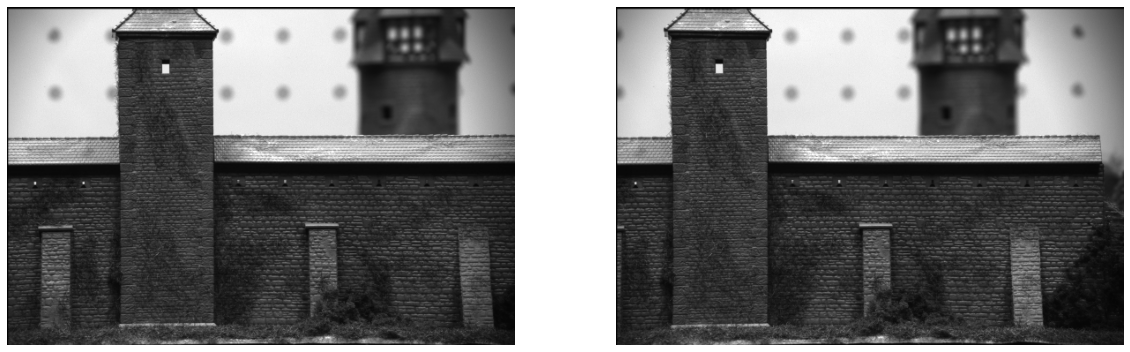

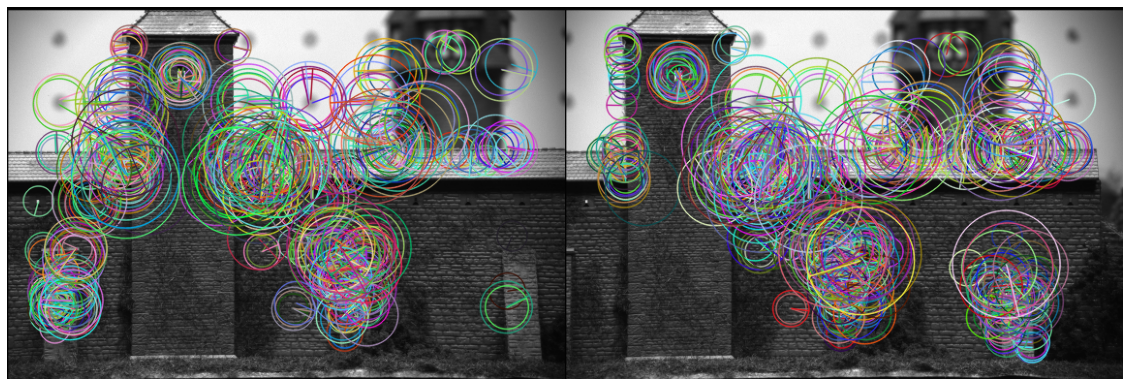

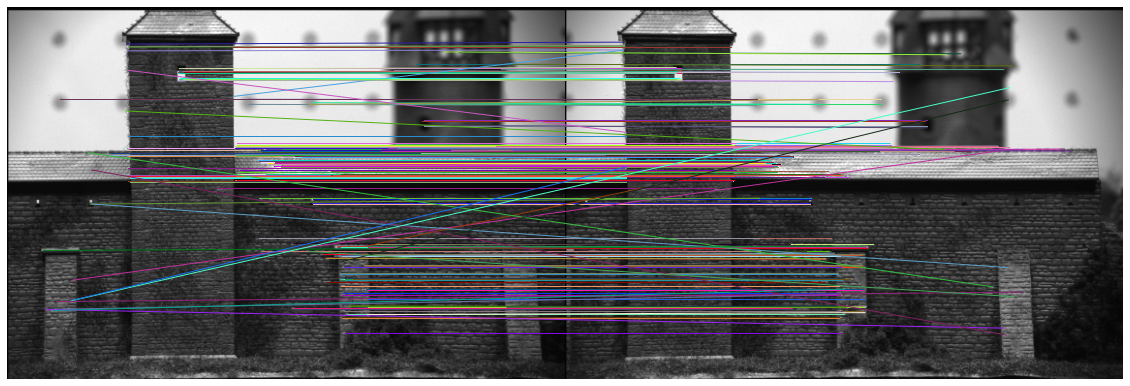

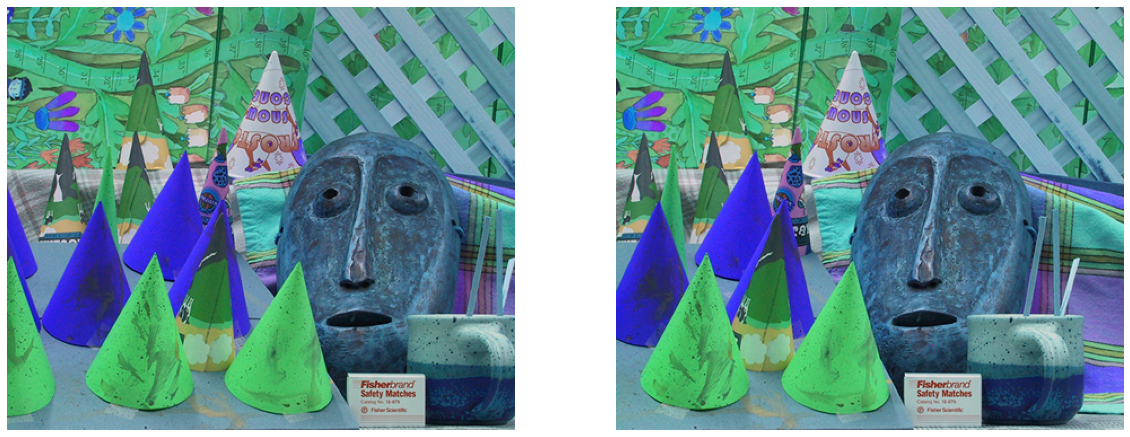

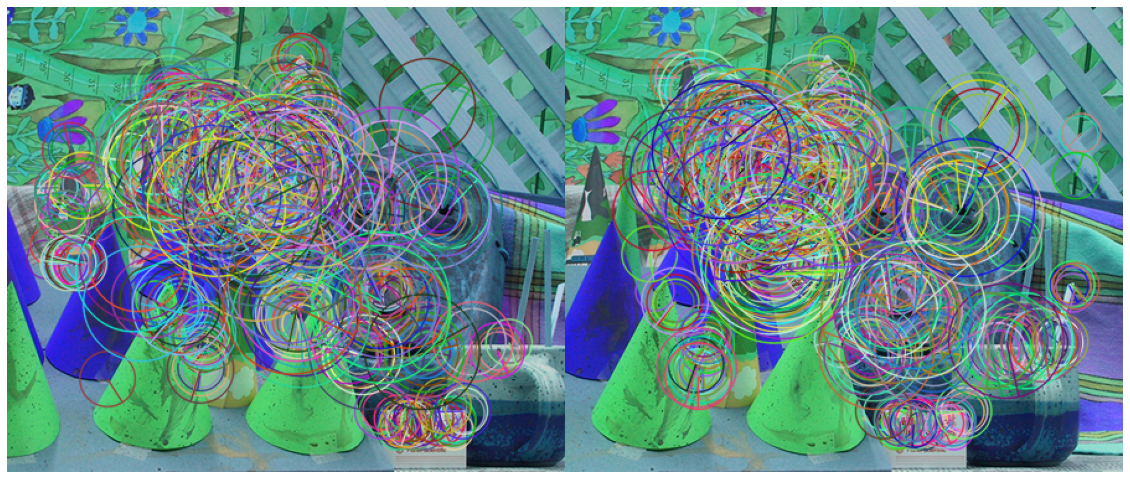

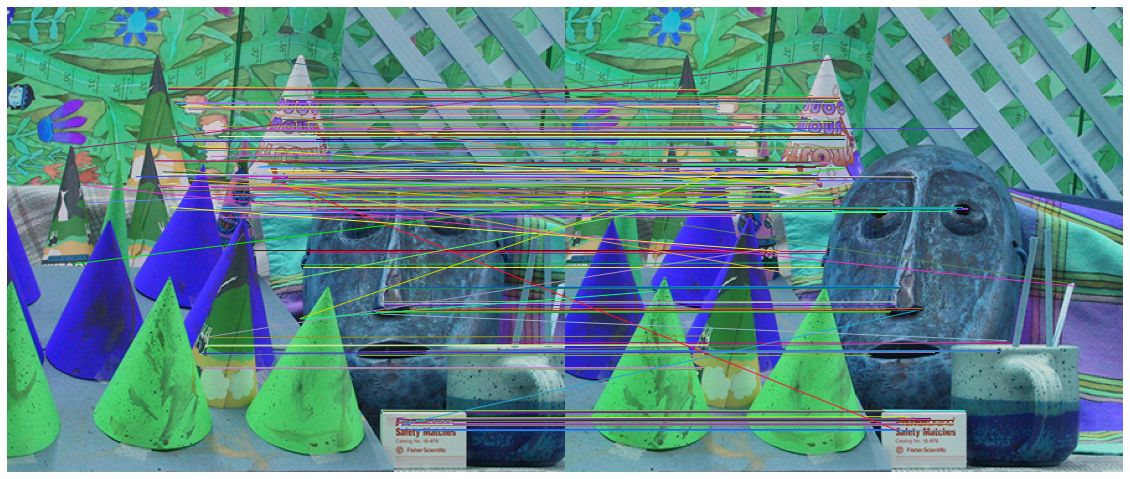

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(20, 9))
axs[0].imshow(image1)
axs[0].axis('off')
axs[1].imshow(image2)
axs[1].axis('off')
plt.show()
corr1,kp1,kp2,x1_1,x2_1 = find_features(image1,image2)
draw_liers(image1,image2,corr1,kp1,kp2)
fig, axs = plt.subplots(1, 2, figsize=(20, 9))
axs[0].imshow(image3)
axs[0].axis('off')
axs[1].imshow(image4)
axs[1].axis('off')
plt.show()
corr2,kp1,kp2,x1_2,x2_2 = find_features(image3,image4)
draw_liers(image3,image4,corr2,kp1,kp2)

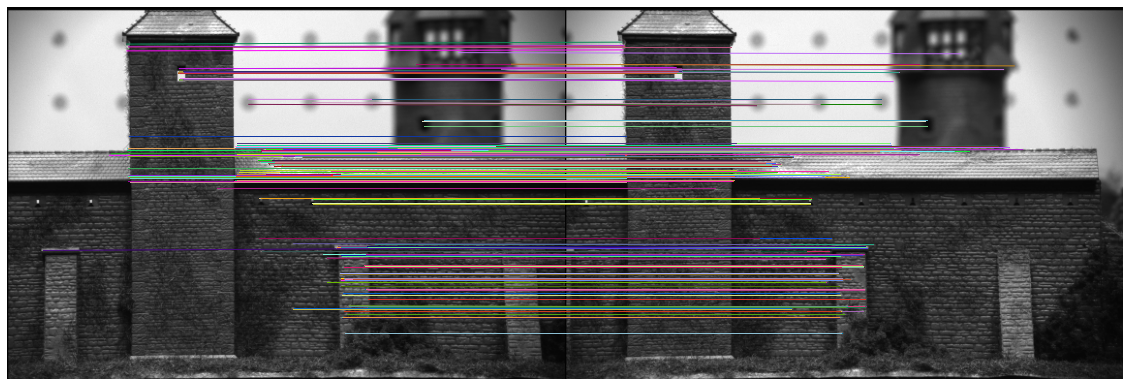

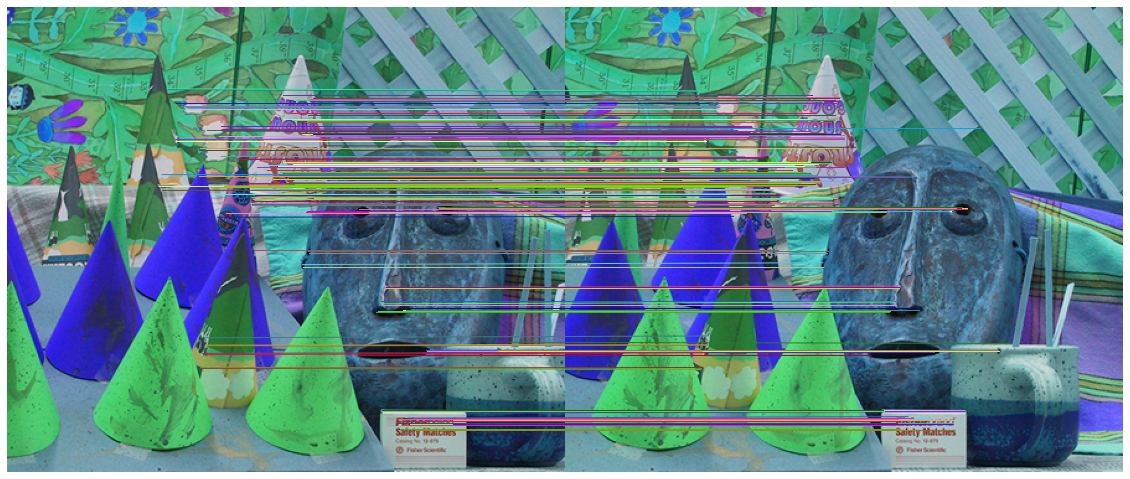

In [6]:
F1,x1_1,x2_1,corr1 = ransac(5000,0.99,2,x1_1,x2_1)
draw_liers(image1,image2,corr1,[],[])
F2,x1_2,x2_2,corr2 = ransac(5000,0.99,2,x1_2,x2_2)
draw_liers(image3,image4,corr2,[],[])

In [7]:
from tqdm.notebook import tqdm
from time import sleep

#image3 = cv2.resize(image3, (100,100), interpolation = cv2.INTER_AREA)
#image4 = cv2.resize(image4, (100,100), interpolation = cv2.INTER_AREA)
disparity_vertical = np.zeros(image3.shape[0:2])
disparity_horizontal = np.zeros(image3.shape[0:2])
size = 5
gray3 = cv2.cvtColor(image3, cv2.COLOR_BGR2GRAY)
gray4 = cv2.cvtColor(image4, cv2.COLOR_BGR2GRAY)
PRINT = False
for i in range(image3.shape[0]):
    print(i)
    for j in range(image3.shape[1]):
        patch1 = get_subwindow(image3,[i,j],size)
        if(PRINT):
            cv2.imshow('patch1',patch1)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
        patch1_normalized = patch1/np.linalg.norm(patch1)
        a,b,c = F1.dot(np.array([i,j,1]))
        ncc = []
        idx_ncc = []
        if(abs(b)>abs(a)):
            for m in range(image4.shape[0]):
                n = int((-c-a*m)/b)
                if n>= 0 and n<image4.shape[1]:
                    patch2 = get_subwindow(image4,[m,n],size)
                    patch2_normalized = patch2/np.linalg.norm(patch2)
                    ncc.append(np.sum(patch1_normalized*patch2_normalized))
                    idx_ncc.append([m,n])
                    if(PRINT):
                        cv2.imshow(str(np.sum(patch1_normalized*patch2_normalized)),patch2)
                        cv2.waitKey(0)
                        cv2.destroyAllWindows()
        if(abs(b)<=abs(a)):
            for n in range(image4.shape[1]):
                m = int((-c-b*n)/a)
                if m>=0 and m<image4.shape[0]:
                    patch2 = get_subwindow(image4,[m,n],size)
                    patch2_normalized = patch2/np.linalg.norm(patch2)
                    ncc.append(np.sum(patch1_normalized*patch2_normalized))
                    if(PRINT):
                        cv2.imshow(str(np.sum(patch1_normalized*patch2_normalized)),patch2)
                        cv2.waitKey(0)
                        cv2.destroyAllWindows()
                    idx_ncc.append([m,n])
        if(len(ncc)>0):
            i_sel,j_sel = idx_ncc[ncc.index(max(ncc))]
            if(abs(i_sel - i)+abs(j_sel -j) <= 20):
                disparity_vertical[i,j] = i_sel - i
                disparity_horizontal[i,j] = j_sel -j

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [12]:
abs(disparity).shape

(375, 450, 3)

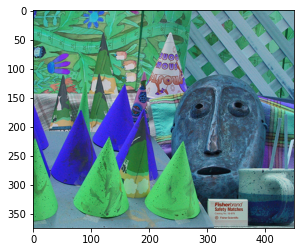

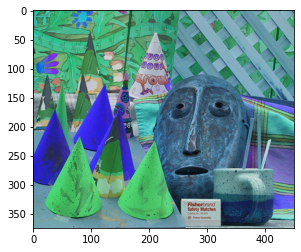

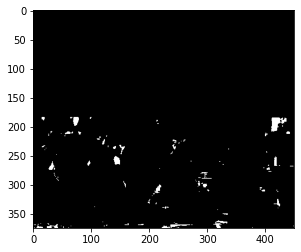

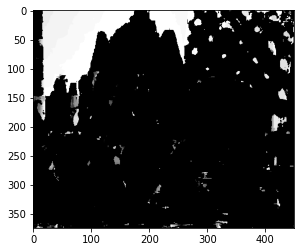

In [9]:
# Normalize disparity to [0,255]
tmp = copy.deepcopy(disparity_vertical)
disparity_norm_v = np.floor((tmp-np.min(tmp))*1./(np.max(tmp)-np.min(tmp))*255.)
tmp = copy.deepcopy(disparity_horizontal)
disparity_norm_h = np.floor((tmp-np.min(tmp))*1./(np.max(tmp)-np.min(tmp))*255.)

# Visualization
plt.figure(1)
plt.imshow(image3)
plt.figure(2)
plt.imshow(image4)
plt.figure(3)
plt.imshow(np.abs(disparity_vertical).astype('uint8'),cmap=cm.Greys_r)
plt.figure(4)
plt.imshow(np.abs(disparity_horizontal).astype('uint8'),cmap=cm.Greys_r)
plt.show()

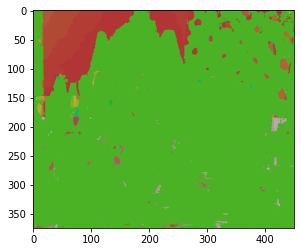

In [14]:
disparity = np.zeros([image3.shape[0],image3.shape[1],3])
disparity[:,:,0] = np.arctan2(disparity_norm_h[:,:],disparity_norm_v[:,:])
tmp = copy.deepcopy(disparity[:,:,0])
disparity[:,:,0] = np.floor((tmp-np.min(tmp))*1./(np.max(tmp)-np.min(tmp))*179.)
disparity[:,:,1] = (disparity_norm_h[:,:]**2+disparity_norm_v[:,:]**2)**0.5
tmp = copy.deepcopy(disparity[:,:,1])
disparity[:,:,1] = np.floor((tmp-np.min(tmp))*1./(np.max(tmp)-np.min(tmp))*255.)
disparity[:,:,2] = 0.7*255
disparity = cv2.cvtColor(disparity.astype('uint8'), cv2.COLOR_HSV2RGB)
plt.figure(1)
plt.imshow(disparity.astype('uint8'))

In [8]:
disparity_vertical = np.zeros(image3.shape)
disparity_horizontal = np.zeros(image3.shape)
size = 5

In [13]:
i,j = 300,300 
a,b,c = F1.dot(np.array([i,j,1]))
if(abs(b)>abs(a)):
    for m in range(image4.shape[0]):
        n = int((-c-a*m)/b)
        print(m,n)
else:
    for n in range(image4.shape[1]):
        m = int((-c-b*n)/a)
        print(m,n)

299 0
299 1
299 2
299 3
299 4
299 5
299 6
299 7
299 8
299 9
299 10
299 11
299 12
299 13
299 14
299 15
299 16
299 17
299 18
299 19
299 20
299 21
299 22
299 23
299 24
299 25
299 26
299 27
299 28
299 29
299 30
299 31
299 32
299 33
299 34
299 35
299 36
299 37
299 38
299 39
299 40
299 41
299 42
299 43
299 44
299 45
299 46
299 47
299 48
299 49
299 50
299 51
299 52
299 53
299 54
299 55
299 56
299 57
299 58
299 59
299 60
299 61
299 62
299 63
299 64
299 65
299 66
299 67
299 68
299 69
299 70
299 71
299 72
299 73
299 74
299 75
299 76
299 77
299 78
299 79
299 80
299 81
299 82
299 83
299 84
299 85
299 86
299 87
299 88
299 89
299 90
299 91
299 92
299 93
299 94
299 95
299 96
299 97
299 98
299 99
299 100
299 101
299 102
299 103
299 104
299 105
299 106
299 107
299 108
299 109
299 110
299 111
299 112
299 113
299 114
299 115
299 116
299 117
299 118
299 119
299 120
299 121
299 122
299 123
299 124
299 125
299 126
299 127
299 128
299 129
299 130
299 131
299 132
299 133
299 134
299 135
299 136
299 137
299 13

In [43]:
disparity_vertical = np.zeros(image3.shape)
disparity_horizontal = np.zeros(image3.shape)
size = 11
for i in range(image3.shape[0]):
    for j in range(image3.shape[1]):
        patch1 = get_subwindow(image3,[i,j],size)
        cv2.imshow('patch1',patch1)
        cv2.waitKey()
        cv2.destroyAllWindows()
        patch1_normalized = patch1/np.linalg.norm(patch1)
        a,b,c = F1.dot(np.array([i,j,1]))
        ncc = []
        idx_ncc = []
        if(abs(b)>abs(a)):
            for m in range(image4.shape[0]):
                n = int((-c-a*m)/b)
                if n>= 0 and n<image4.shape[1]:
                    patch2 = get_subwindow(image4,[m,n],size)
                    cv2.imshow('patch2',patch2)
                    cv2.waitKey()
                    cv2.destroyAllWindows()
                    patch2_normalized = patch2/np.linalg.norm(patch2)
                    ncc.append(np.sum(patch1_normalized*patch2_normalized))
                    idx_ncc.append([m,n])   
        else:
            for n in range(image4.shape[1]):
                m = int((-c-b*n)/a)
                if m>=0 and m<image4.shape[0]:
                    patch2 = get_subwindow(image4,[m,n],size)
                    cv2.imshow('patch2',patch2)
                    cv2.waitKey()
                    cv2.destroyAllWindows()
                    patch2_normalized = patch2/np.linalg.norm(patch2)
                    ncc.append(np.sum(patch1_normalized*patch2_normalized))
                    idx_ncc.append([m,n])
        if(len(ncc)>0):
            i_sel,j_sel = idx_ncc[ncc.index(max(ncc))]
            disparity_vertical[i,j] = i_sel - i
            disparity_horizontal[i,j] = j_sel -j

KeyboardInterrupt: 

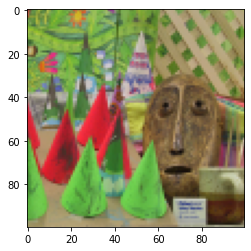

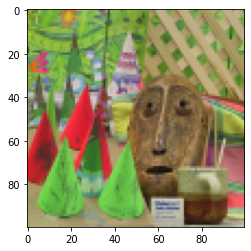

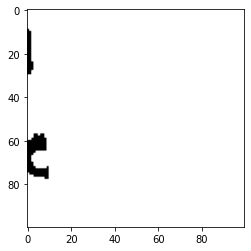

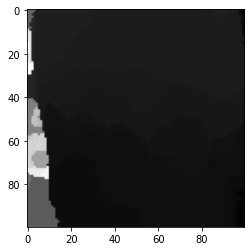

In [40]:
# Normalize disparity to [0,255]
tmp = copy.deepcopy(disparity_vertical)
disparity_norm_v = np.floor((tmp-np.min(tmp))*1./(np.max(tmp)-np.min(tmp))*255.)
tmp = copy.deepcopy(disparity_horizontal)
disparity_norm_h = np.floor((tmp-np.min(tmp))*1./(np.max(tmp)-np.min(tmp))*255.)

# Visualization
plt.figure(1)
plt.imshow(image3)
plt.figure(2)
plt.imshow(image4)
plt.figure(3)
plt.imshow(np.abs(disparity_norm_v).astype('uint8'),cmap=cm.Greys_r)
plt.figure(4)
plt.imshow(np.abs(disparity_norm_h).astype('uint8'),cmap=cm.Greys_r)
plt.show()

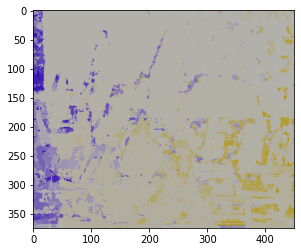

In [19]:
disparity = np.zeros([image3.shape[0],image3.shape[1],3])
disparity[:,:,0] = np.arctan2(disparity_horizontal[:,:,0],disparity_vertical[:,:,0])
tmp = copy.deepcopy(disparity[:,:,0])
disparity[:,:,0] = np.floor((tmp-np.min(tmp))*1./(np.max(tmp)-np.min(tmp))*179.)
disparity[:,:,1] = (disparity_horizontal[:,:,0]**2+disparity_vertical[:,:,0]**2)**0.5
tmp = copy.deepcopy(disparity[:,:,1])
disparity[:,:,1] = np.floor((tmp-np.min(tmp))*1./(np.max(tmp)-np.min(tmp))*255.)
disparity[:,:,2] = 0.7*255
disparity = cv2.cvtColor(disparity.astype('uint8'), cv2.COLOR_HSV2RGB)
plt.figure(1)
plt.imshow(disparity.astype('uint8'))

In [10]:
gray3.shape

(375, 450)

In [38]:
disparity_horizontal

array([[ 22.,  22.,  22., ..., -10., -15., -15.],
       [ 22.,  22.,  22., ..., -10., -11., -15.],
       [ 22.,  22.,   0., ..., -10., -11., -15.],
       ...,
       [ 18.,  17.,  17., ..., -14., -15., -16.],
       [ 18.,  18.,  17., ..., -14., -15., -16.],
       [ 18.,  18.,  18., ..., -14., -15., -16.]])